## Linear Regression Analysis of Covid-19 data for Canada, Italy, India, and the United States
#### By: Ian

##### Description:
This notebook uses the linear regression model ElasticNet to predict total Covid-19 cases per million in April for four countries.

### Import needed Libraries

In [122]:
##Import Key Libraries for use
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from pandas.tseries.offsets import DateOffset

### Import and Scrub Data from Github

In [123]:
neededColumns = ["date","location","total_cases_per_million","new_cases_per_million","total_deaths_per_million","human_development_index","median_age","population"]

#Import CSV
covid19Dataframe = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")
#Remove Smoothed Columns from dataframe
covid19Dataframe = covid19Dataframe[covid19Dataframe.iso_code.str.contains("CAN")| (covid19Dataframe.iso_code.str.contains("IND")) | (covid19Dataframe.iso_code.str.contains("ITA")) | (covid19Dataframe.iso_code.str.contains("USA"))]
covid19Dataframe = covid19Dataframe[neededColumns]
covid19Dataframe.dropna(subset=["new_cases_per_million"],inplace=True)
covid19Dataframe.dropna(subset=["total_deaths_per_million"],inplace=True)
covid19Dataframe["date"] = pd.to_datetime(covid19Dataframe["date"])
#Reset Index
covid19Dataframe.reset_index(drop=True, inplace=True)

#Import Comparison Data set containing data from March. The data set we are using stops in February
marchCovidData = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/Covid-IND_CAN-USA_ITA-March.csv")
marchCovidData = marchCovidData[neededColumns]
marchCovidData.dropna(subset=["new_cases_per_million"],inplace=True)
marchCovidData.dropna(subset=["total_deaths_per_million"],inplace=True)
marchCovidData["date"] = pd.to_datetime(marchCovidData["date"])
#Reset Index
marchCovidData.reset_index(drop=True, inplace=True)


### Define Notebook Functions

In [124]:
#Prints the Scores from the run of the algorithum against the data
def printMetrics(f_test, f_predictions):
    print(f"Score: {explained_variance_score(f_test, f_predictions):.2f}")
    print(f"MAE: {mean_absolute_error(f_test, f_predictions):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(f_test, f_predictions)):.2f}")
    print(f"r2: {r2_score(f_test, f_predictions):.2f}")

In [125]:
targetColumn = "total_cases_per_million"

### Train and Define the Model
##### Description:
The below features provided the best model. Both new cases per million and total deaths per million had the most impact on the model. Additionally, adding more columns actually causes the model to get worse.

Features Uses
- new_cases_per_million
- total_deaths_per_million
- human_development_index*
- median_age
- population

*The human is defined as a composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506

In [126]:
featureColumns = ["new_cases_per_million","total_deaths_per_million","human_development_index","median_age","population"]

features=covid19Dataframe[featureColumns]
target=covid19Dataframe[targetColumn]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
model = ElasticNet(random_state=1,max_iter=10000)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
printMetrics(y_test, predictions)

Score: 0.92
MAE: 3185.80
RMSE: 4726.74
r2: 0.92


### Predict total cases per million for April
##### Description:
Using data from the model trained about and data from the month of March where total_deaths_per_million and new_cases_per_million features are increased and decreased by 15%.

In [127]:
aprilCovidDataIncrease = marchCovidData.copy()

aprilCovidDataIncrease["total_deaths_per_million"] = (aprilCovidDataIncrease["total_deaths_per_million"] * .15) + aprilCovidDataIncrease["total_deaths_per_million"]
aprilCovidDataIncrease["new_cases_per_million"] = (aprilCovidDataIncrease["new_cases_per_million"] * .15) + aprilCovidDataIncrease["new_cases_per_million"]
aprilCovidDataIncrease["date"] = aprilCovidDataIncrease["date"] + DateOffset(months=1)
aprilCovidDataIncrease.insert(6,"model","increase",True)

aprilCovidDataIncrease["predictions"] = aprilCovidDataIncrease[featureColumns].apply(
    lambda s: model.predict(s.values[None])[0], axis=1
)

##### DECREASE
aprilCovidDataDecrease = marchCovidData.copy()
aprilCovidDataDecrease["total_deaths_per_million"] = aprilCovidDataDecrease["total_deaths_per_million"] - (aprilCovidDataDecrease["total_deaths_per_million"] * .15)
aprilCovidDataDecrease["new_cases_per_million"] = aprilCovidDataDecrease["new_cases_per_million"] - (aprilCovidDataDecrease["new_cases_per_million"] * .15)
aprilCovidDataDecrease["date"] = aprilCovidDataDecrease["date"] + DateOffset(months=1)
aprilCovidDataDecrease.insert(6,"model","decrease",True)

aprilCovidDataDecrease["predictions"] = aprilCovidDataDecrease[featureColumns].apply(
    lambda s: model.predict(s.values[None])[0], axis=1
)

aprilCovidDataPredictions = pd.concat([aprilCovidDataIncrease, aprilCovidDataDecrease])
#combinedDataframe

### Plot the predictions
##### Data Analysis:
- For both the US and Italy a 15% increase in total_deaths_per_million and new_cases_per_million would cause a significant increase in total cases per million.
- If there is a 15% decrease in total_deaths_per_million and new_cases_per_million for the US and Italy then total cases per million would only increase slightly and remain far flatter.
- Canada would see an increase but nowhere near as large as the US or Italy. Additionally, Canada remains flatter regardless of an increase or decrease in total_deaths_per_million and new_cases_per_million.
- India's total cases per million prediction draws into question the quality of their data. Given how vastly different India's trend and lines appear from the other three countries it seems there data is not as accurate.

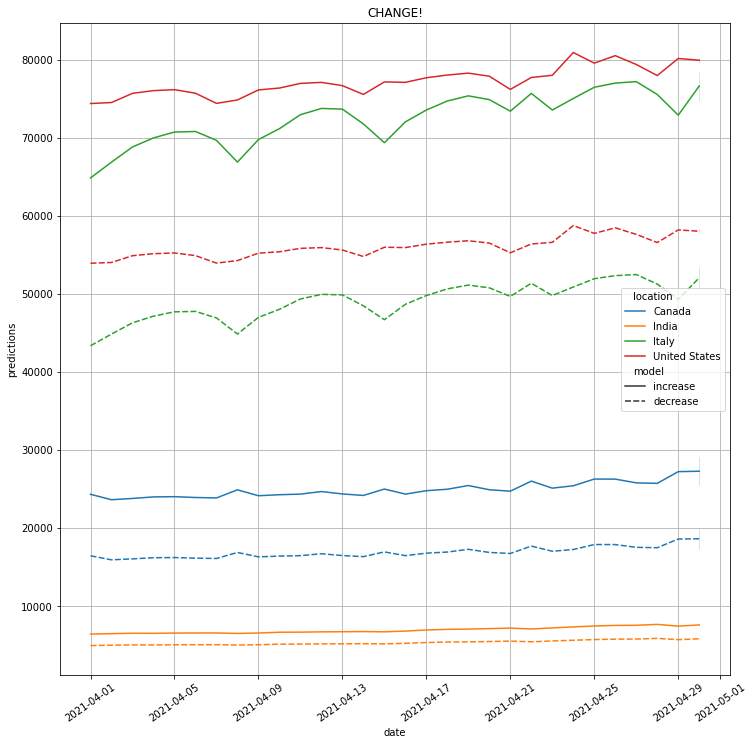

In [128]:
# #Sets figure size
plt.figure(figsize=(12,12))
#rotates the x axis
plt.xticks(rotation=35)
#ensures grid lines are on the image
plt.grid(b=True,which='major')
chartPollution = sns.lineplot(data=aprilCovidDataPredictions, x="date", y="predictions", hue="location",style="model").set_title("CHANGE!")
chartPollution.figure.canvas.draw()
